In [1]:
# because of version problems,
# Jupyter notebook prints too many warning messsage
# This parts helps to ignore these warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%pwd

'/home/qiao/dev/giao/havingfun/detecting/segmentation/unet34'

In [4]:
print(torch.cuda.is_available())

True


In [5]:
path = Path('/home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613')

path_img = path/'imgs/'
path_label = path/'labels'
codes = ['Smoke', 'Flame', 'Background']
path_img

Path('/home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/imgs')

In [6]:
fnames = get_image_files(path_img)
print('======> example of training image', fnames[0])
lbl_names = get_image_files(path_label)
print('======> example of training label', lbl_names[0])

======> example of training image /home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/imgs/M300_20220613_41.2_13.png
======> example of training label /home/qiao/dev/giao/datasets/M300bounding/Step2_training/20220613/labels/label_M300_20220613_41.2_31.png


In [7]:
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

In [8]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 4,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((385, 480))], # wide: 960/2 = 480, hight: 770/2 = 385
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [9]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

In [10]:
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# original, pixel level accuracy
def pixel_accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

# auc: area under the curve, a general computing using the trapezoidal rule.
# roc_curve: Receiver operating characteristic (ROC); xlabel: false positve; ylabel: true positive
# roc_auc_score: area under the receiver operating characteristic curve
def auc_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    Auc_score = roc_auc_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), multi_class='ovr')
    return Auc_score

# average precision score: area under the precision-recal curve
def precision_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # for multilabel-indicator, `pos_label` is fixed to 1.
    precision_score = average_precision_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu())
    return precision_score

# f1-score
def f1_score_macro(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    F1 = f1_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), average = 'macro') # , average = 'macro'
    return F1

# metrics = evaluate_acc
metrics = [pixel_accuracy, auc_score, precision_score, f1_score_macro]
# metrics = roc_curve
# metrics = evaluate_ap

In [11]:
# callback metrics works for CNN-learner
# but it seems strange for such dynamic U-net
callback_fns = [Precision, Recall, FBeta(average = 'macro', beta = 3.)]

In [12]:
# using original resnet34-based U-net, therefore no `attention`
learn = unet_learner(dls, models.resnet34, metrics = metrics, self_attention=False)

In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [14]:
# using the pretrained params --- go as a transfer learning
learn.load('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/models/u34unfreeze_ori_step1_20220711')

SuggestedLRs(valley=3.630780702224001e-05)

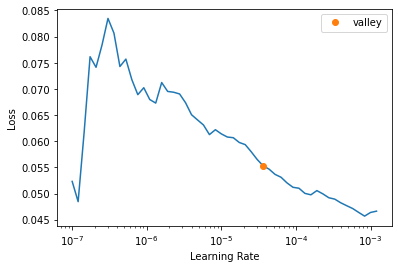

In [15]:
# finding appropriate learning rate
# learn.lr_find(stop_div=False, num_it=20)
learn.lr_find()

In [16]:
lr = 3.63e-5

In [17]:
# forthe transfer-traing, slight tranining epochs are needed
learn.fit_one_cycle(11, slice(lr))

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,precision_score,f1_score_macro,time
0,0.048547,0.023328,0.991329,0.667181,0.248321,0.483530,00:20
1,0.031554,0.018163,0.992850,0.776366,0.416980,0.538036,00:18
2,0.023813,0.016938,0.993469,0.763219,0.447178,0.541659,00:18
3,0.019453,0.015716,0.993908,0.798221,0.499009,0.557270,00:18
4,0.016524,0.016883,0.992923,0.906481,0.527812,0.570851,00:18
5,0.014575,0.015326,0.994153,0.845838,0.540579,0.572470,00:18
6,0.013165,0.015281,0.993891,0.861787,0.534828,0.571957,00:18
7,0.011852,0.016405,0.994095,0.832389,0.529916,0.567586,00:18
8,0.011042,0.015867,0.993735,0.874707,0.534740,0.572080,00:18
9,0.010481,0.015997,0.993942,0.857814,0.534557,0.570807,00:18


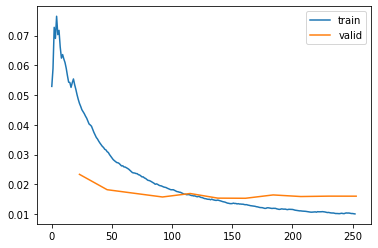

In [18]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [19]:
learn.save('u34freeze_ori_step2_20220711')
learn.load('u34freeze_ori_step2_20220711')

SuggestedLRs(valley=2.0892961401841603e-05)

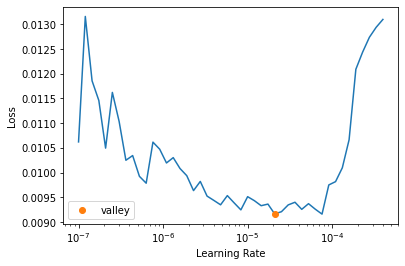

In [20]:
learn.unfreeze()
learn.lr_find()

In [21]:
lr_max = 2.08e-5

In [23]:
learn.fit_one_cycle(3, lr_max)

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,precision_score,f1_score_macro,time
0,0.008771,0.016287,0.993872,0.869600,0.535689,0.571257,00:19
1,0.008911,0.016711,0.993817,0.868193,0.528019,0.570690,00:19
2,0.008557,0.016699,0.994171,0.849116,0.537337,0.571391,00:19


In [ ]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
learn.show_results()
learn.save('u34unfreeze_step2_20220711')